In [2]:
from dataset import load_dataset, preprocess

from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import nltk
from nltk import sent_tokenize
import seaborn as sns

import gensim
from gensim.models import KeyedVectors
import gensim.downloader
import numpy as np

import tensorflow as tf

from sklearn.utils import compute_sample_weight
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import collections
import random
import tiktoken

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
sns.set_theme()


2024-05-20 15:40:44.389739: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 15:40:44.609125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 15:40:45.727118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zarmeyo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zarmeyo/nltk_data...
[nltk_data]   Package wor

In [23]:
dataset = load_dataset()
ds = preprocess(dataset)
dataset.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


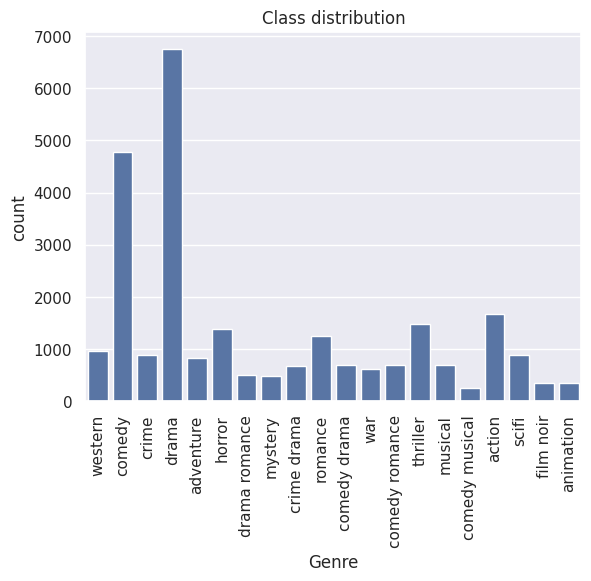

In [24]:
sns.countplot(x='Genre', data=ds)
plt.title("Class distribution")
plt.xticks(rotation=90)
plt.show()

# Word2Vec

In [5]:
plots = list(ds['Plot'])
plots_as_string = " ".join(plots)

In [6]:
def tokenize(text):
    return [[w.lower() for w in word_tokenize(s)] for s in sent_tokenize(text)]

def tokenizer_sw(text):
    l = [[w.lower() for w in word_tokenize(s)] for s in sent_tokenize(text)]
    l = [[w for w in s if w not in stopwords.words('english')] for s in l]
    return l

In [7]:
plots_tokenized = tokenize(plots_as_string)

In [24]:
model = gensim.models.Word2Vec(plots_tokenized, min_count=5, workers=14)
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
del model

In [25]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
sims = wv.most_similar('drama', topn=10)
sims

[('comedy', 0.8389410972595215),
 ('thriller', 0.7259464859962463),
 ('narrative', 0.6985074877738953),
 ('documentary', 0.6968528628349304),
 ('musical', 0.686352550983429),
 ('storyline', 0.6792124509811401),
 ('comic', 0.6766525506973267),
 ('melodrama', 0.674228310585022),
 ('sequence', 0.6698220372200012),
 ('fiction', 0.6658077239990234)]

# A la main

In [8]:
sw = stopwords.words('english')
count = collections.Counter(plots_as_string.split()).most_common()
vocab = {word: idx for idx, (word, _) in enumerate(count)}
reverse_vocab = {idx: word for word, idx in vocab.items()}

In [9]:
def generate_training_data(sentences, vocab, window_size=2):
    pairs = []
    for sentence in sentences:
        words = sentence.split()
        for idx, word in enumerate(words):
            for neighbor in words[max(idx - window_size, 0): min(idx + window_size + 1, len(words))]:
                if neighbor != word:
                    pairs.append((vocab[word], vocab[neighbor]))
    return pairs

In [10]:
pairs = generate_training_data(plots, vocab)

In [11]:
vocab_size = len(vocab)
embedding_dim = 128

In [12]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.nce_weights = tf.Variable(tf.random.truncated_normal([vocab_size, embedding_dim], stddev=1.0 / np.sqrt(embedding_dim)))
        self.nce_biases = tf.Variable(tf.zeros([vocab_size]))

    def call(self, inputs, labels):
        embed = self.embedding(inputs)
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=self.nce_weights,
                           biases=self.nce_biases,
                           labels=labels,
                           inputs=embed,
                           num_sampled=num_sampled,
                           num_classes=vocab_size))
        return loss

In [ ]:
def generate_batch(pairs, batch_size):
    random.shuffle(pairs)
    for i in range(0, len(pairs), batch_size):
        batch = pairs[i:i+batch_size]
        batch_inputs, batch_labels = zip(*batch)
        yield np.array(batch_inputs), np.array(batch_labels).reshape(-1, 1)

batch_size = 64
dataset = tf.data.Dataset.from_generator(lambda: generate_batch(pairs, batch_size),
                                         output_signature=(tf.TensorSpec(shape=(None,), dtype=tf.int32),
                                                           tf.TensorSpec(shape=(None, 1), dtype=tf.int32)))

In [14]:
num_steps = 10000
learning_rate = 0.001
num_sampled = 10

model_w2V = Word2Vec(vocab_size, embedding_dim)
optimizer = tf.keras.optimizers.SGD(learning_rate)

In [15]:
for step, (batch_inputs, batch_labels) in enumerate(dataset.repeat(num_steps)):
    with tf.GradientTape() as tape:
        loss = model_w2V(batch_inputs, batch_labels)
    gradients = tape.gradient(loss, model_w2V.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_w2V.trainable_variables))
    
    if step % 2000 == 0:
        print("Step: ", step, " Loss: ", loss.numpy())

    if step >= num_steps:
        break

Step:  0  Loss:  43.907578
Step:  2000  Loss:  60.756165
Step:  4000  Loss:  58.706394
Step:  6000  Loss:  68.26632
Step:  8000  Loss:  86.545715
Step:  10000  Loss:  63.267906


In [16]:
trained_embeddings = model_w2V.embedding.weights[0].numpy()
i = 0
for word, idx in vocab.items():
    if i > 10:
        break
    print(f"Word: {word}, Embedding: {trained_embeddings[idx]}")
    i += 1

Word: the, Embedding: [-0.00474128 -0.0014229   0.00619363  0.0287718   0.02225269  0.03179214
 -0.02274863  0.05376334 -0.03119509 -0.05114242 -0.02625156  0.00129877
  0.01851054  0.03247052  0.01901601  0.00454378 -0.02161847  0.07167414
 -0.03724079 -0.00119922 -0.06937374 -0.06093874  0.06465172  0.02577175
 -0.00061979 -0.03910367 -0.00907428  0.03160519 -0.0116403   0.01114696
  0.00913838  0.01156875 -0.00984432  0.01471341 -0.08446468 -0.03715039
 -0.04657516 -0.01176282 -0.05005462  0.02311075 -0.04152367  0.06967998
  0.02465019  0.02438236 -0.02176113 -0.04045707  0.00707395  0.00994031
  0.01753616 -0.0038226  -0.0211077   0.08456114  0.00717475  0.00486849
 -0.05935739 -0.02933888  0.00799077 -0.02608755  0.02418737  0.03597933
 -0.00438691  0.0514431  -0.00714699  0.05191327 -0.03421735 -0.0488502
 -0.00844121 -0.0570354   0.03180947  0.00596792 -0.02775283 -0.04430155
 -0.06735402  0.01019571 -0.05754874  0.00711424  0.03499765  0.05664878
 -0.03570602 -0.00596332 -0.01

# Entrainement du model

In [17]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])
    
    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [25]:
X = dataset['Plot']
y = dataset['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [61]:
model = make_pipeline(
    CountVectorizer(tokenizer=word_tokenize, ngram_range = (1,1)),
    LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000))

In [62]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                 precision    recall  f1-score   support

        action       0.40      0.40      0.40       328
     adventure       0.38      0.44      0.41       152
     animation       0.50      0.44      0.47        61
        comedy       0.51      0.53      0.52       973
  comedy drama       0.13      0.10      0.11       146
comedy musical       0.18      0.13      0.15        53
comedy romance       0.20      0.16      0.18       153
         crime       0.24      0.26      0.25       188
   crime drama       0.16      0.15      0.15       125
         drama       0.51      0.54      0.53      1335
 drama romance       0.13      0.13      0.13        98
     film noir       0.25      0.19      0.22        69
        horror       0.58      0.51      0.54       284
       musical       0.29      0.27      0.28       133
       mystery       0.28      0.37      0.32        89
       romance       0.33      0.31      0.32       252
         scifi       0.

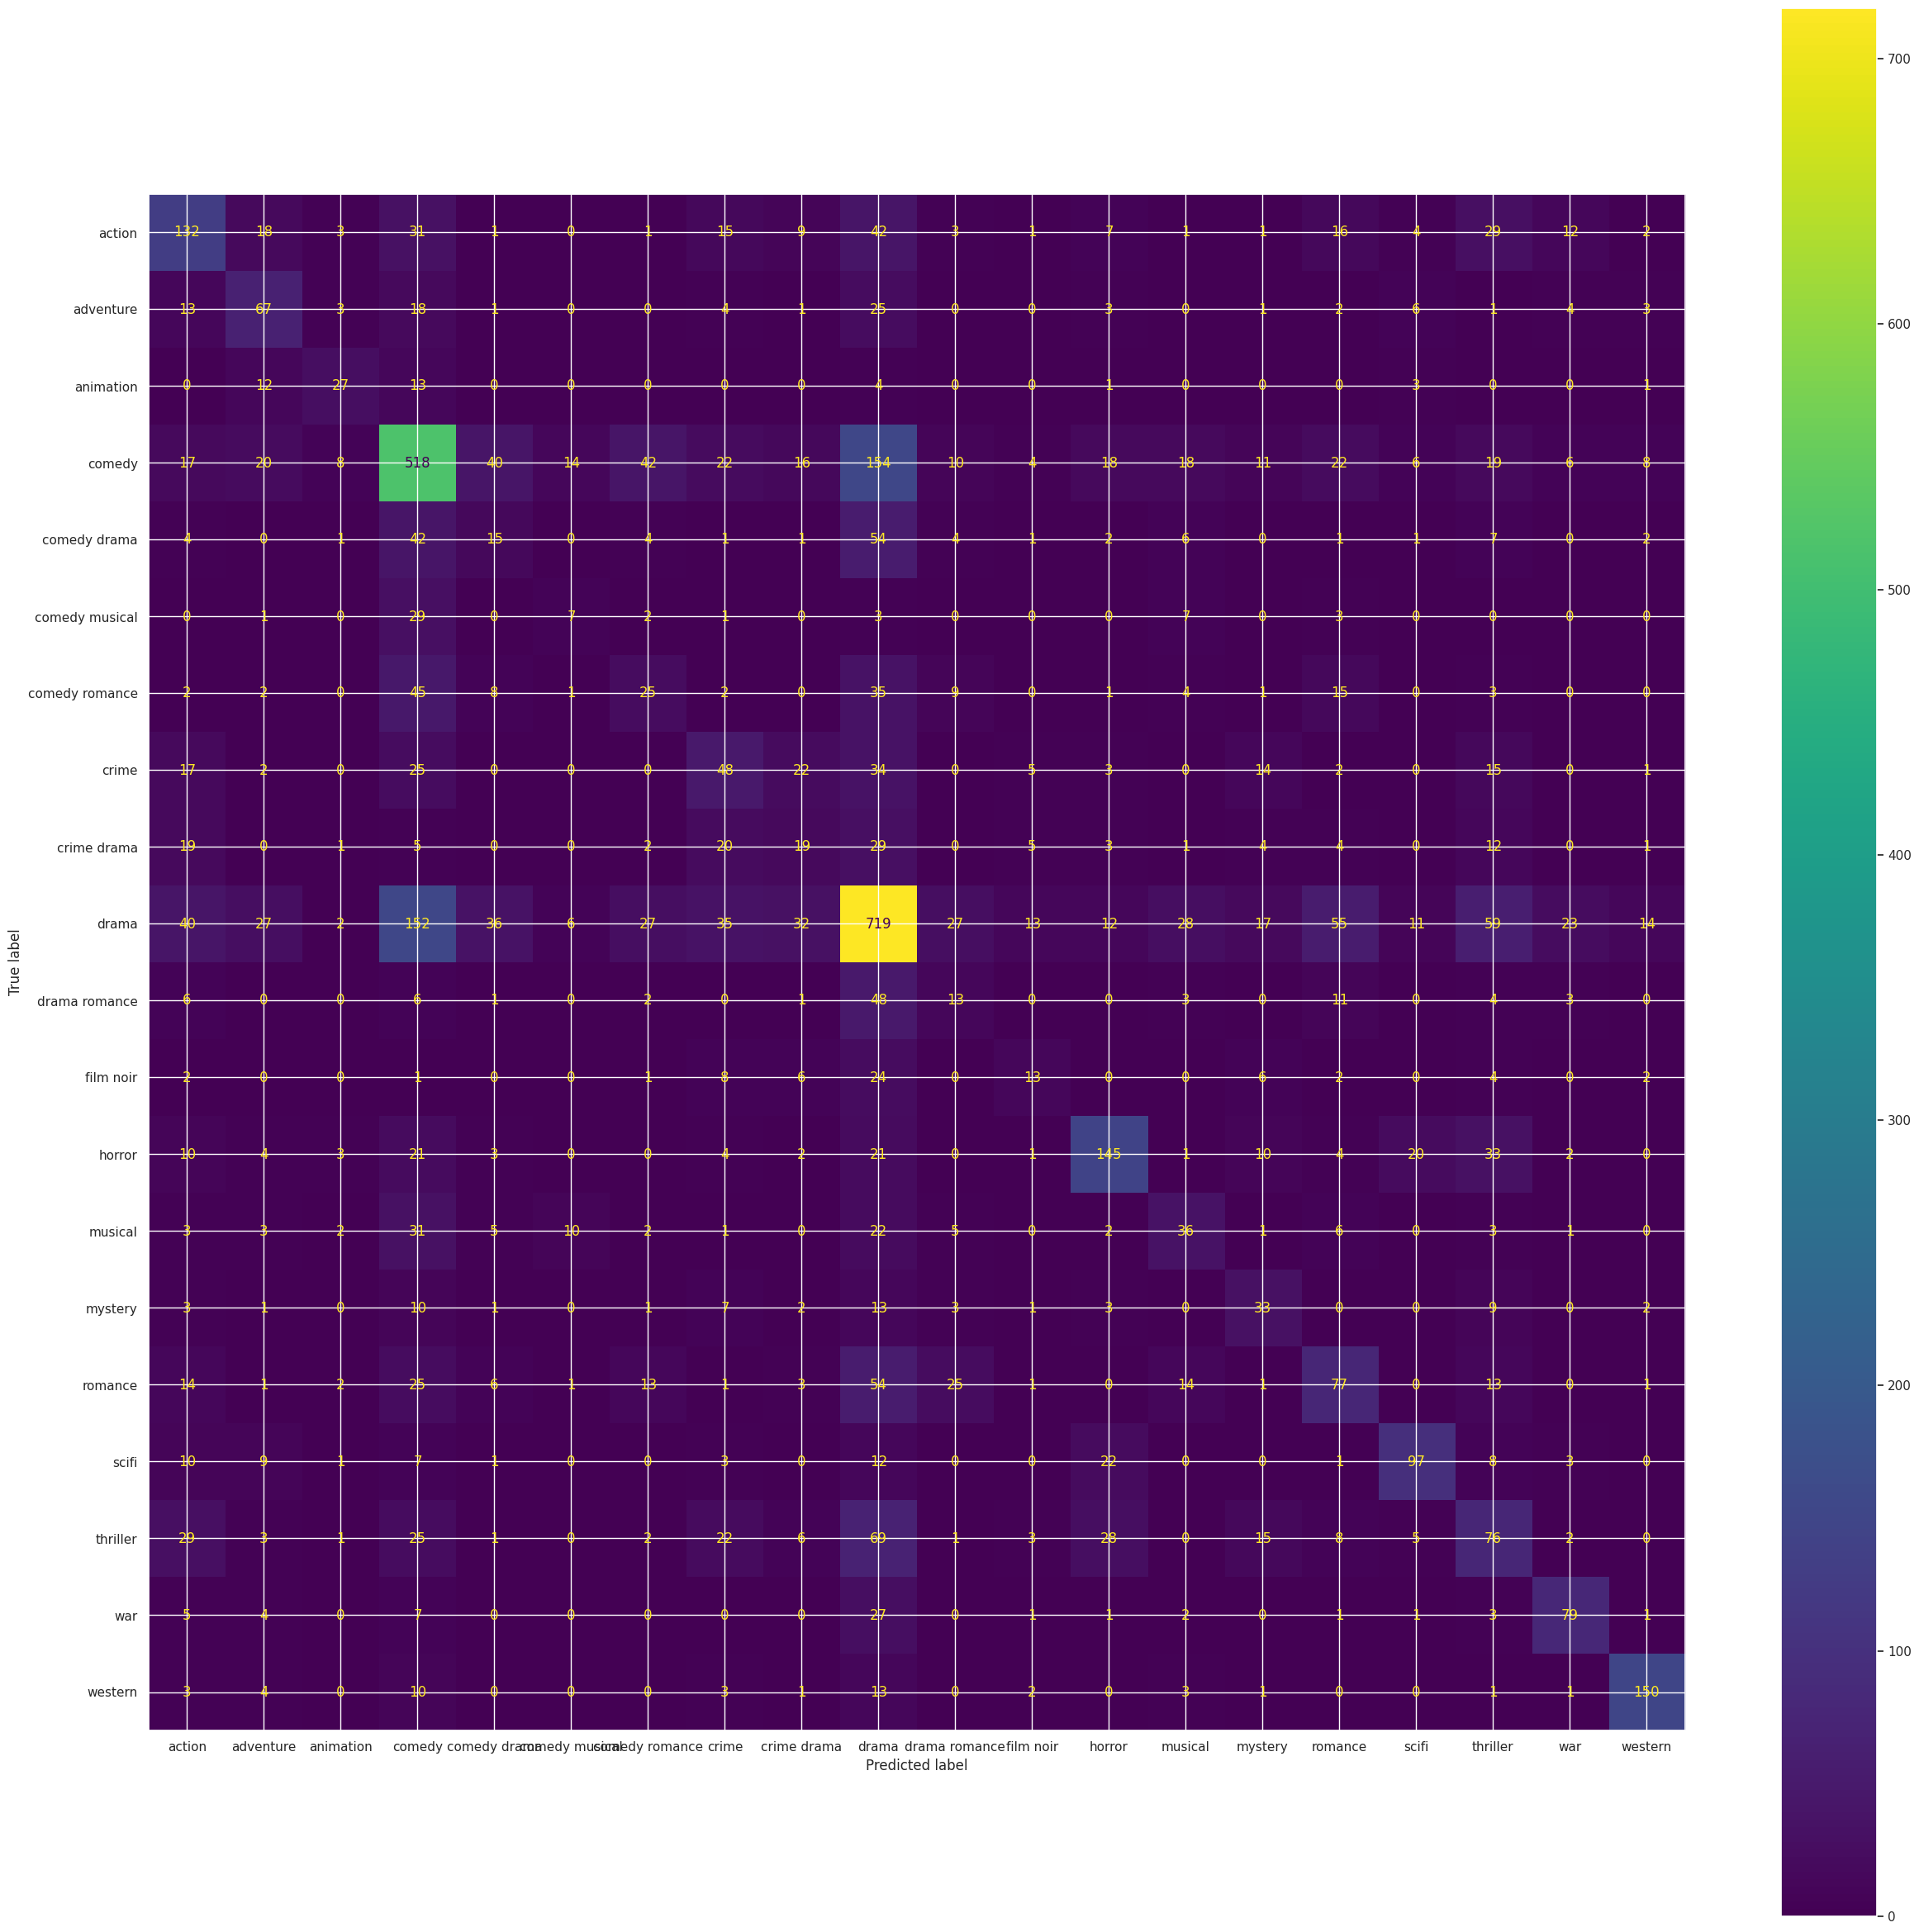

In [63]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)

fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(ax=ax)

In [66]:
def tokenize_gpt(doc): 
    return [str(token) for token in tiktoken.encoding_for_model("gpt-4").encode(doc)]

In [74]:
model2 = make_pipeline(
    CountVectorizer(tokenizer=tokenize_gpt, ngram_range = (1,1)),
    LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 2000))

In [75]:
model2.fit(X_train, y_train)

y_pred2 = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred2))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
                 precision    recall  f1-score   support

        action       0.36      0.34      0.35       328
     adventure       0.30      0.35      0.32       152
     animation       0.43      0.41      0.42        61
        comedy       0.50      0.51      0.50       973
  comedy drama       0.09      0.10      0.09       146
comedy musical       0.12      0.08      0.09        53
comedy romance       0.16      0.13      0.15       153
         crime       0.22      0.26      0.24       188
   crime drama       0.15      0.16      0.16       125
         drama       0.50      0.52      0.51      1335
 drama romance       0.11      0.10      0.11        98
     film noir       0.19      0.22      0.20        69
        horror       0.61      0.50      0.55       284
       musical       0.27      0.28      0.27       133
       mystery       0.27      0.34      0.30        89
       romance       0.29      0.30      0.29       252
         scifi       0.

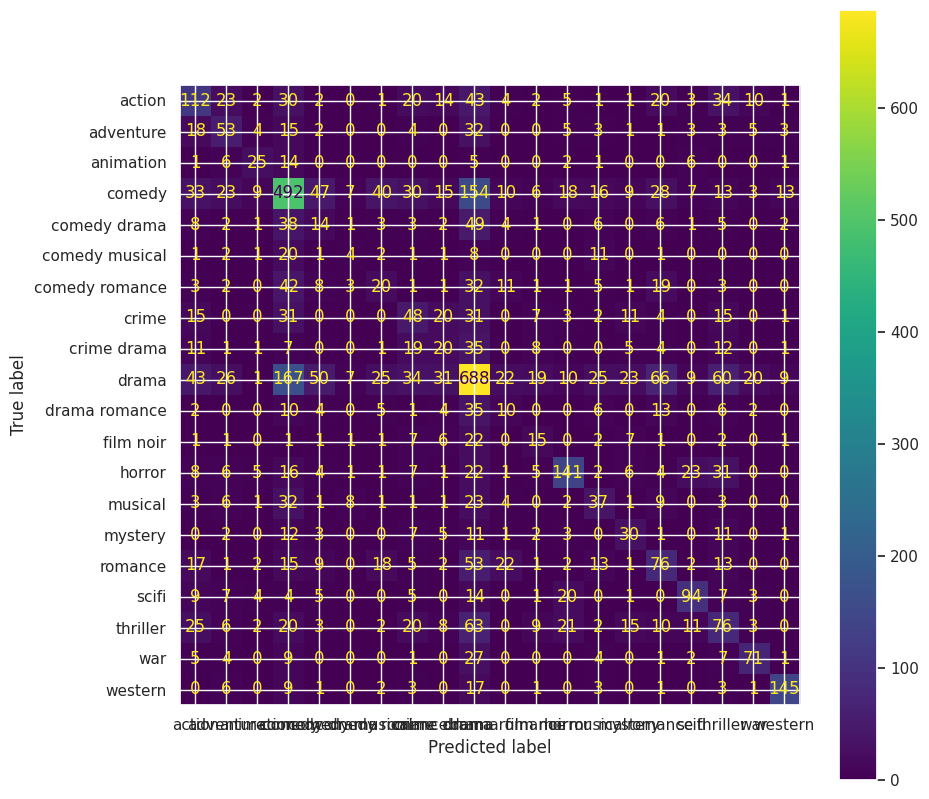

In [82]:
cm2 = confusion_matrix(y_test, y_pred, labels=model.classes_)
cmp2 = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)

fig, ax = plt.subplots(figsize=(10,10))
cmp2.plot(ax=ax)

In [31]:
X = dataset['Plot'].apply(lambda x: " ".join([x for x in x.split() if x not in sw]))
y = dataset['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [32]:
model = make_pipeline(
    CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 1)),
    LogisticRegression(random_state=42, class_weight='balanced', penalty='l2', max_iter=1000))

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

fig, ax = plt.subplots(figsize=(30, 30))
cmp.plot(ax=ax)